# Sech - Frank's Method

In [1]:
import sympy as sp
import math as m

from matplotlib import pyplot as plot
from scipy.optimize import fsolve
from sympy import Symbol, lambdify

import DistExampB as db

from Map import LogRatio
from LocUtil import Grid1, LogGridInt, UnZip

## Set Up

#### constants

In [2]:
nPlot = 201

#### problem

In [3]:
dist = db.ExampB()

#### maping

In [4]:
xSym = Symbol('x')
zSym = Symbol('z')
map_ = LogRatio(xSym, zSym, xRange=(0, 2))
map_.forSym

log(x/(2 - x))

In [5]:
X2Z = map_.Forward
Z2X = map_.Inverse

#### bases

In [6]:
hSym = Symbol('h', positive=True)
wSym = Symbol('w', positive=True)

zkSym = Symbol('zk', real=True)

In [7]:
baseZ = wSym / sp.pi  / sp.cosh((zSym - zkSym) / wSym)
baseZ

w/(pi*cosh((z - zk)/w))

Note.  This base is only good for beta = 1/2.  For other values of beta the scaling needs to be 
	w ** ((1 - beta)/beta) / pi.

In [8]:
BaseZ = lambdify((zSym,zkSym,wSym), baseZ)

## Constrained Fit to PDF

In [9]:
PdfZ = lambda z: dist.Pdf(map_.Inverse(z))

In [10]:
timeTrunc = 1e-4

In [11]:
zn = fsolve(lambda z: PdfZ(z) - timeTrunc, -5)[0]
zx = fsolve(lambda z: PdfZ(z) - timeTrunc, 11)[0]
zRange = (zn,zx)
zRange

(-4.688412546913663, 11.002066500871658)

In [12]:
def FrankApprox(F, zRange, nSech):
	# parse arguments
	assert(1 < nSech)
	zMin,zMax = zRange
	
	# compute sech points and h
	h = (zMax - zMin) / (nSech - 1)
	sechZ = Grid1(*zRange, nSech)
	sechV = tuple(F(z) for z in sechZ)
	
	return (sechZ,sechV, m.sqrt(h))

In [13]:
def Interp0(sechZ,sechV,width, z):
	result = sum(sv * BaseZ(z,sz,width) for (sz,sv) in zip(sechZ,sechV))
	return result

In [14]:
def Interp1(sechApprox, zGrid):
	result = tuple(Interp0(*sechApprox, z) for z in zGrid)
	return result

In [15]:
distZ = lambda z: dist.Pdf(map_.Inverse(z))

In [16]:
approx100 = FrankApprox(distZ, zRange, 100)

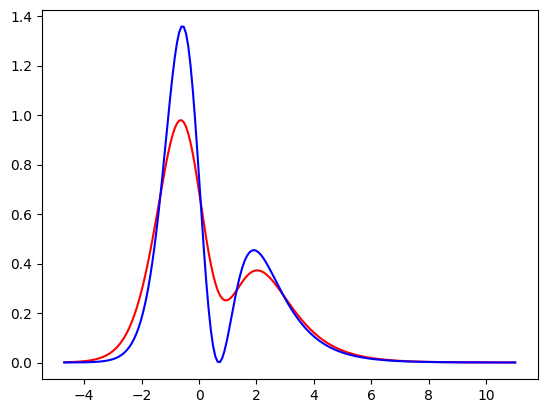

In [17]:
zGrid = Grid1(*zRange, nPlot)
est = Interp1(approx100, zGrid)

pdf = tuple(distZ(z) for z in zGrid)
plot.plot(zGrid,est, c='red')

plot.plot(zGrid, pdf, c='blue')

In [18]:
approx1k = FrankApprox(distZ, zRange, 1_000)

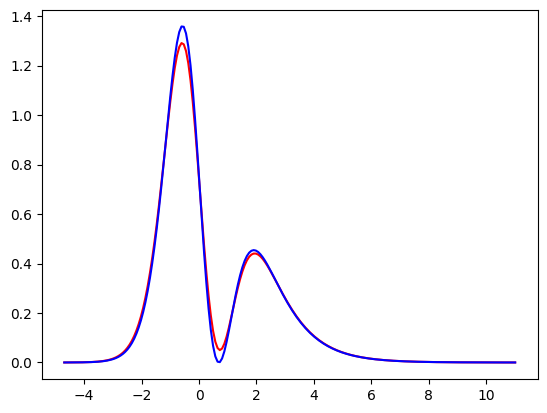

In [19]:
zGrid = Grid1(*zRange, nPlot)
est = Interp1(approx1k, zGrid)

plot.plot(zGrid,est, c='red')

plot.plot(zGrid, pdf, c='blue')

This is painfully slow convergence.

## Check the order of convergence

In [22]:
def ErrorZ(sechApprox, F):
	# parse arguments
	sechZ,sechV, width = sechApprox
	
	nSech = len(sechZ)
	zMin,zMax = sechZ[0], sechZ[nSech - 1]
	
	# define differences	
	Diff = lambda z: Interp0(sechZ,sechV,width, z) - F(z)
	
	extZMin, extZMax = 2*zMin, 2*zMax
	nSinc = 4 * nSech
	h = (extZMax - extZMin) / (nSinc - 1)
	
	sincZ = Grid1(extZMin,extZMax, nSinc)
	sincDiff = tuple(Diff(z) for z in sincZ)
	
	result = m.sqrt(h * sum(d*d for d in sincDiff))
	return result

In [23]:
ErrorZ(approx1k, distZ)

0.07298331331023465

In [24]:
nL = LogGridInt(10,500, 50)

In [25]:
info = []
for n in nL:
	approx = FrankApprox(distZ, zRange, n)
	rms = ErrorZ(approx, distZ)
	
	info.append((n,rms))

(0.1, 1)

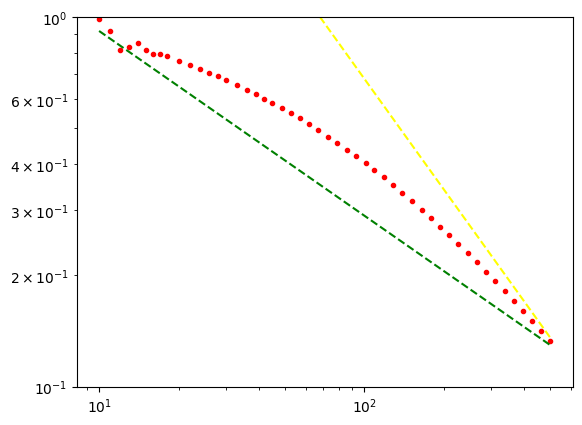

In [42]:
fig,ax = plot.subplots()

_,rms = UnZip(info)
plot.loglog(nL,rms, '.', c='red')

ref = tuple(2.9 / m.sqrt(n) for n in nL)
plot.loglog(nL,ref, '--', c='green')

ref = tuple(68 / n for n in nL)
plot.loglog(nL,ref, '--', c='yellow')

ax.set_ylim(1e-1,1)